In [11]:
#import needed libraries
import sklearn.datasets as ds
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import random

In [12]:
def prepareSklearnData(SKLDataset):
    """This function extracts necessary data out of SickitLearn Dataset"""
    
    X = SKLDataset["data"]
    Y = SKLDataset["target"]
    # merge targets and features in a single numpy array  
    dataset = np.c_[X, Y]
    return dataset, SKLDataset.target_names, SKLDataset.feature_names, X, Y 

In [13]:
SKLDataset = ds.load_iris()
dataset, target_names, feature_names, X, Y = prepareSklearnData(SKLDataset)

In [14]:
class explorer:
    """This class explores a dataset of features and targets and returns observations for analysis"""
    
    def __init__(self, dataset, feature_names):
        self.dataset = dataset
        self.feature_names = feature_names

    def getShape(self):
        return self.dataset.shape

    def getSize(self):
        return self.dataset.size 

    def getSummary(self):
        print(f"This data set contains : {self.getShape()[0]} rows, {self.getShape()[1]} columns and {self.getSize()} data points.")

    def getHead(self, n=5):
        # construct the first n rows in a tabular form along with the columns names
        print(tabulate(self.dataset[:n,:], headers=np.append(self.feature_names, "Target")))

    def getTail(self, n=5):
        # construct the first n rows in a tabular form along with the columns names
        print(tabulate(self.dataset[-n:,:], headers=np.append(self.feature_names, "Target")))
    

In [15]:
#Testing of the explorer class
ex = explorer(dataset, feature_names)
ex.getSummary()

This data set contains : 150 rows, 5 columns and 750 data points.


In [16]:
ex.getHead()
ex.getTail()

  sepal length (cm)    sepal width (cm)    petal length (cm)    petal width (cm)    Target
-------------------  ------------------  -------------------  ------------------  --------
                5.1                 3.5                  1.4                 0.2         0
                4.9                 3                    1.4                 0.2         0
                4.7                 3.2                  1.3                 0.2         0
                4.6                 3.1                  1.5                 0.2         0
                5                   3.6                  1.4                 0.2         0
  sepal length (cm)    sepal width (cm)    petal length (cm)    petal width (cm)    Target
-------------------  ------------------  -------------------  ------------------  --------
                6.7                 3                    5.2                 2.3         2
                6.3                 2.5                  5                   1.9         2

In [17]:
class Model():
    """This class builds a classification model using the KNN algorithm and trains it 
           based on labeled data to make prediction out of new unlabeled data"""
    
    X_train, y_train = None, None
    
    def __init__(self, K):
        self.setK(K)
        self.trained = False
      
    def getK(self):
        return self.K
      
    def setK(self, newK):
        if newK<1:
            raise ValueError("K may not be smaller than 1")                
        self.K = int(newK)
        
    def splitData(self, X, Y, TSize = 0.25):
        '''Split a given dataset into training data and testing data'''
        
        if X.shape[0] != Y.shape[0]:
            raise ValueError("Shapes of x and y do not match")   
        X_train, X_test,y_train, y_test = X, [], Y, []
        # get the required length of the testing arrays
        TLength = int(X.shape[0]*TSize)+1
        # swap random rows from the training data into the testing data
        for i in range(TLength):
            # generate a random integer between zero and the current length of training data
            r = random.randint(0, len(Y)-i)
            #swap rows
            y_test = np.append(y_test, y_train[r])
            y_train = np.delete(y_train, r, axis = 0)
            X_test.append(np.array(X_train[r]))
            X_train = np.delete(X_train, r, axis = 0)
        # return the training and testing data in numpy arrays    
        return X_train, np.array(X_test),y_train, np.array(y_test)
    
    def fit(self, X, Y):
        '''Fit data into the model and assign them to the local attributes'''
        
        if X.shape[0] != Y.shape[0]:
            raise ValueError("Shapes of x and y do not match")
        self.X_train, self.y_train = X, Y
        self.trained = True

    def predict(self, X_test):
        '''Returns the predicted target values to a given set of features, based on the models training data'''
        
        if not self.trained:
            raise RuntimeError("Model not trained yet. Prediction not possible")
        #Storing the target values
        y_pred = np.empty(X_test.shape[0], dtype=np.int8) 
        index=0
        for i in X_test:
            #Calculating distances
            dist = np.array([np.linalg.norm(j-i) for j in self.X_train]) 
            #Joining distances and target values into one array
            trainData = np.column_stack((self.y_train, dist))            
            trainData = trainData[trainData[:,1].argsort()]
            kNeighbors = trainData[:self.K]
            #Number of classes present in the k-nearest-neighbors
            n = int(np.amax(kNeighbors[:,0])) 
            #Storing the frequency of each class in the k-nearest-neighbors
            buckets = np.zeros(n+1) 
            for j in kNeighbors:
                buckets[int(j[0])] += 1
            y_pred[index] = np.argmax(buckets)         
            index+=1
        return y_pred
    
    
    def getScore(self, y_test, y_pred):
        '''Calculate the accuracy of the model'''
        
        if y_test.shape[0] != y_pred.shape[0]:
            raise ValueError("Shapes of y_test and y_pred do not match")
        err = 0
        # check if every value of the testing data matches the predicted value
        for i in range(len(y_test)):
            if y_test[i] != y_pred[i]:
                err += 1
        return (len(y_test)-err)/len(y_test)
    
    def getConfusionMatrix(self, y_test, y_pred):
        '''Build a confusion matrix to demonstrate mispredicted values'''
        
        if y_test.shape[0] != y_pred.shape[0]:
            raise ValueError("Shapes of y_test and y_pred do not match")
        
        arr = np.c_[y_test, y_pred]
        matrix = np.zeros((len(set(y_test)), len(set(y_test))))
        # Check for each target value of the testing data if it matches the predicted value
        for i in range(len(y_test)):
            # if the the values match increment the true positive section
            if arr[i,0] == arr[i,1]:
                matrix[int(arr[i,0]),int(arr[i,0])] += 1
            else:
                # if the values don't match increment the false positive section
                matrix[int(arr[i,0]),int(arr[i,1])] +=1
        return matrix
    
    def plot(self, feature_names, X_test, y_pred):
        '''Plot the distribution of the predictors in scatter diagrams, each representing the correlation between two features.'''
        
        for i in range(X_test.shape[1]):
            for j in range(i+1, X_test.shape[1]):
                # plot a comparision of two features and their distribution
                 plt.scatter(X_test[:,i],X_test[:,j], c=y_pred)
                 plt.xlabel(feature_names[i])
                 plt.ylabel(feature_names[j])
                 plt.show()

In [18]:
#Testing of the Model class
model = Model(6)
X_train, X_test,y_train, y_test = model.splitData(X, Y)
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = model.getScore(y_test, pred)

In [19]:
print(f'The accuracy of the model is {round(score*100,2)}%')
cm = model.getConfusionMatrix(y_test, pred)
print(cm)

The accuracy of the model is 94.74%
[[11.  0.  0.]
 [ 0. 13.  1.]
 [ 0.  1. 12.]]


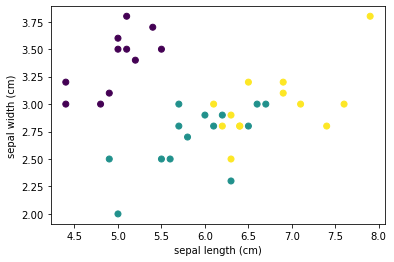

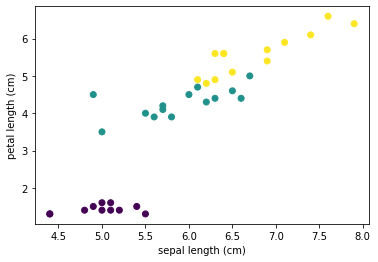

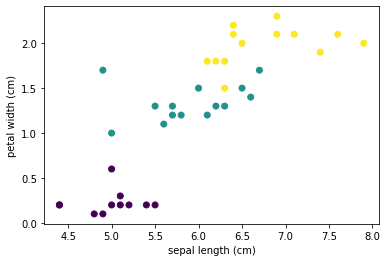

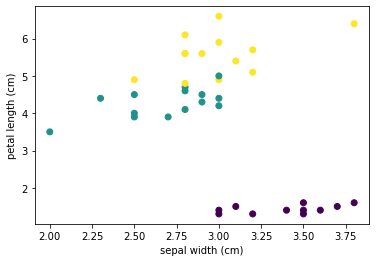

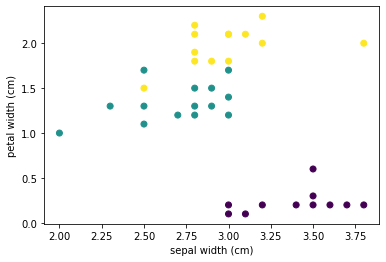

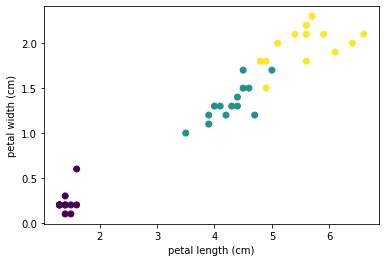

In [20]:
model.plot(feature_names, X_test, pred)